# ACERIM - Planetary data science in Python

Christian Tai Udovicic (cj.taiudovicic@gmail.com)

## Housekeeping

See [github.com/cjtu/acerim](github.com/cjtu/acerim) for the project homepage and installation instructions. Full API documentation is available at [readthedocs.org](readthedocs.org/projects/acerim). As a strong believer in collaboration and open-source research, if you think there is feature missing, are having trouble getting started, or would like to contribute to ACERIM, please feel free to get in touch!

## Introduction

ACERIM (Automated Crater Ejecta Region of Interest Mapper) is a data analysis library for importing, processing, analyzing image data of planetary impact craters. Benefits of using this library include:

- Simple importing of image and crater data
- Functions for extracting craters and their ejecta blankets from images
- Ability to run custom tailored statistics on any or all regions of interest
- Integrates with all of your favourite Python libraries (numpy, pandas, matplotlib, etc)
- Reproducible (and citable!) reseach workflows

I developed ACERIM to simplify the unwieldy process of importing crater and image data into Python and to formalize some common statistical analyses done with crater data. 

To get started using ACERIM in a Python program, we will import some helpful modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## AceDataset 

First we will import image data from a GeoTIFF file into an `AceDataset` object. All file formats supported by `gdal` are also supported by the `AceDataset`: 

In [2]:
# Get path to this directory using the os module
from acerim.aceclasses import AceDataset
import os.path
data_dir = os.path.dirname(os.path.abspath("./sample"))
moonADS = AceDataset(data_dir+"/moon.tif")
print(moonADS)

AceDataset object with bounds (90.0N, -90.0S), (-180.0E, 180.0E), radius 6378.137 km, and 4.0 ppd resolution


The sample dataset *moon.tif* is a global lunar geotiff with some geographic information included. For datasets without geotiff tags, geographic information must be set manually. This will also override any automatically included tags:

In [3]:
moonADS = AceDataset(data_dir+"/moon.tif", nlat=90, slat=-90, wlon=-180,
                     elon=180, radius=1737, ppd=4)
print(moonADS)

AceDataset object with bounds (90N, -90S), (-180E, 180E), radius 1737 km, and 4 ppd resolution


The `AceDataset` inherits from `gdal.Dataset` and implements its attributes and methods. One such method is `Dataset.ReadAsArray()`:

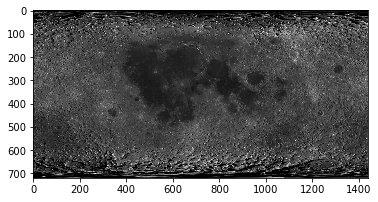

In [4]:
moonarr = moonADS.ReadAsArray(0, 0, 1440, 720)
plt.imshow(moonarr, cmap="gray")
plt.show()

The AceDataset also has a method to help extract square regions of interest (ROIs) around craters. Here, we target the Orientale impact basin located at (19.4S, 92.8W) with radius 327 km.

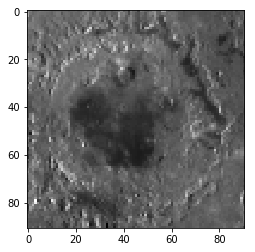

In [5]:
orientaleROI = moonADS.get_roi(-19.4, -92.8, 327)
plt.imshow(orientaleROI, cmap="gray")
plt.show()

The wsize parameter will scale the ROI. The ROI extends out `wsize*radius` from the crater center (by default `wsize=1`).

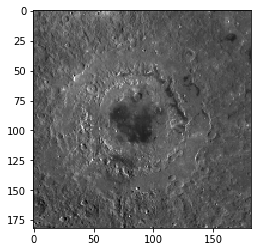

In [6]:
orientaleROI = moonADS.get_roi(-19.4, -92.8, 327, wsize=2)
plt.imshow(orientaleROI, cmap="gray")
plt.show()

The `plot_roi` parameter is a shortcut to plot the roi to the shell and the `mask_crater` parameter automatically applies a mask of NaN to the interior of the crater (this will be useful later in the tutorial).

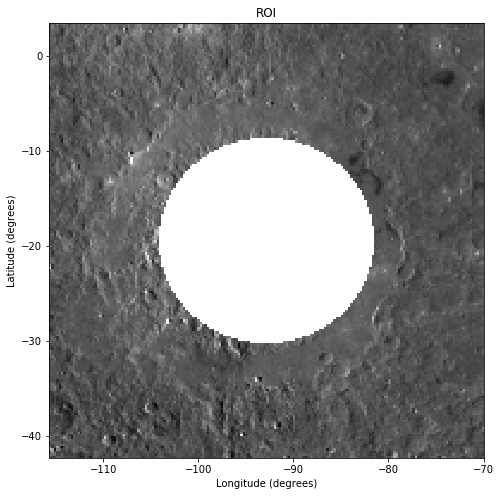

In [7]:
orientaleROI = moonADS.get_roi(-19.4, -92.8, 327, wsize=2, 
                            plot_roi=True, mask_crater=True)

The AceDataset.get_roi() method returns data as a numpy 2D array.

In [8]:
type(orientaleROI)

numpy.ndarray

In [9]:
orientaleROI.shape

(182L, 182L)

In [10]:
np.nanmean(orientaleROI)

73.588141736943328

ROIs which extend beyond the bounds of the `AceDataset` will raise an `OutOfBoundsException`, unless the AceDataset is global and the ROI only crosses the longitude extent. In this case the `get_roi()` method will wrap around to return the desired data.

In [11]:
try:
    moonADS.get_roi(90, 0, 100, plot_roi=True)
except ValueError as e:
    print(e)

Latitude or longitude out of bounds.


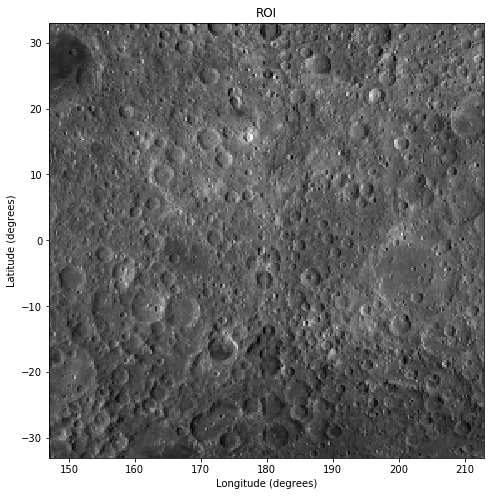

In [12]:
wraped_lon_boundary = moonADS.get_roi(0, 180, 1000, plot_roi=True)

The `AceDataset` and its `get_roi()` method can be used as is to query image data in python, but most ACERIM functions will also require a `CraterDataFrame`.

## CraterDataFrame

The `CraterDataFrame` extends the `pandas.DataFrame` object. All `DataFrame` methods and attributes are available to the `CraterDataFrame` (see [pandas](https://pandas.pydata.org/pandas-docs/stable/) for documentation and info).

In [13]:
# Import craters from csv located at same data_dir as above
from acerim.aceclasses import CraterDataFrame
moonCDF = CraterDataFrame(data_dir+"/craters.csv")  
moonCDF.head()

,Name,Rad,Lat,Lon
0,Olbers D,50.015,10.23,-78.03
1,Schuster,50.040,4.44,146.42
2,Gilbert,50.125,-3.20,76.16
3,Cabeus,50.290,-85.33,-42.13
4,Kovalevskaya Q,50.315,29.18,-131.44


The `CraterDataFrame` requires at least 3 columns of tabular data, the *latitude*, *longitude*, and *radius* of craters in the table. One strength of the `CraterDataFrame` object is that it automatically scans the header row for these three columns and saves a reference to them in the attributes latcol, loncol, and radcol, respectively. This avoids issues with inconsistent naming conventions.

In [14]:
print(moonCDF.latcol, moonCDF.loncol, moonCDF.radcol)

('Lat', 'Lon', 'Rad')


If the columns cannot be located automatically or to manually override them, specify the names of the respective columns as parameters:

In [15]:
moonCDF = CraterDataFrame(data_dir+"/craters.csv", latcol="Lat", loncol="Lon",
                          radcol="Rad")
print(moonCDF.latcol, moonCDF.loncol, moonCDF.radcol)

('Lat', 'Lon', 'Rad')


The `radcol` parameter is important because ACERIM assumes that crater size data is given as a radius. If it does not find a radius column, `CraterDataFrame` will search for a diameter column instead and automatically generate the "radius" column as shown below.

In [16]:
moonCDF = CraterDataFrame(data_dir+"/craters_no_rad.csv")
moonCDF.head()

,Name,Diam,Lat,Lon,radius
0,Olbers D,100.03,10.23,-78.03,50.015
1,Schuster,100.08,4.44,146.42,50.040
2,Gilbert,100.25,-3.20,76.16,50.125
3,Cabeus,100.58,-85.33,-42.13,50.290
4,Kovalevskaya Q,100.63,29.18,-131.44,50.315


This way, when accessing a `CraterDataFrame` by attribute, we can be certain that the correct column of data is read.

In [17]:
moonCDF.head()[moonCDF.radcol]

0    50.015
1    50.040
2    50.125
3    50.290
4    50.315
Name: radius, dtype: float64

The `index_col` parameter can be set to index the `CraterDataFrame` to the ID column, in this case the *Name* column at index 0:

In [18]:
moonCDF = CraterDataFrame(data_dir+"/craters.csv", index_col=0)
moonCDF.head()

,Rad,Lat,Lon
Name,,,
Olbers D,50.015,10.23,-78.03
Schuster,50.040,4.44,146.42
Gilbert,50.125,-3.20,76.16
Cabeus,50.290,-85.33,-42.13
Kovalevskaya Q,50.315,29.18,-131.44


Now craters can be queried by their names using the `.loc[]` pandas DataFrame syntax:

In [19]:
moonCDF.loc['Schuster']

Rad     50.04
Lat      4.44
Lon    146.42
Name: Schuster, dtype: float64

All typical `DataFrame` syntax can be used on the `CratreDataFrame`:

In [20]:
moonCDF.head()[moonCDF.radcol]

Name
Olbers D          50.015
Schuster          50.040
Gilbert           50.125
Cabeus            50.290
Kovalevskaya Q    50.315
Name: Rad, dtype: float64

In [21]:
moonCDF.at['Schuster', 'Lat']

4.4400000000000004

`CraterDataFrames` can also be filtered using "fancy" (boolean) indexing:

In [22]:
moonCDF_gt150 = moonCDF[moonCDF[moonCDF.radcol] > 150] 
moonCDF_gt150.head()

,Rad,Lat,Lon
Name,,,
Bailly,150.280,-66.82,-68.90
Sikorsky-Rittenhouse,155.000,-68.00,111.00
Schrodinger,158.195,-74.73,132.93
Planck,159.730,-57.27,135.34
Mendeleev,162.565,5.38,141.17


In [31]:
moonCDF_20N20S = moonCDF[(moonCDF['Lat'] >= -20) & (moonCDF['Lat'] <= 20)]
moonCDF_20N20S.head()

,Rad,Lat,Lon
Name,,,
Olbers D,50.015,10.23,-78.03
Schuster,50.040,4.44,146.42
Gilbert,50.125,-3.20,76.16
Ventris,50.370,-4.77,157.97
Fridman,50.725,-12.48,-126.88


## Acefunctions

With a functioning `AceDataset` and `CraterDataframe`, all of functions from `acefunctions.py` can now be used. For example, statistics can be quickly calculated on crater ejecta blankets and returned as tabular data:

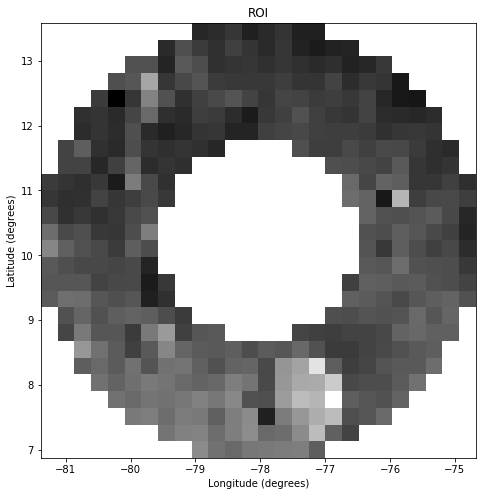

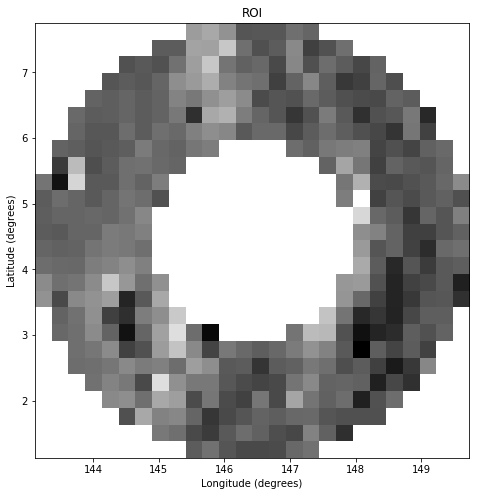

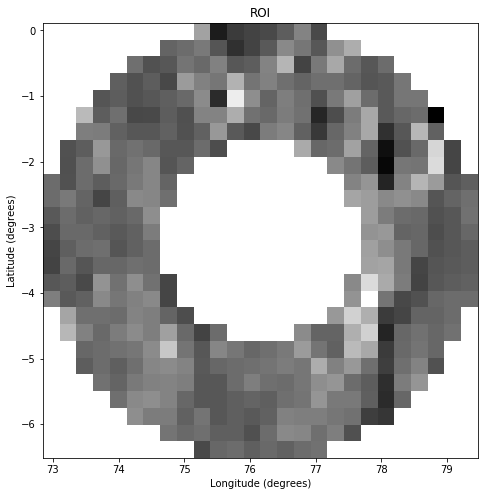

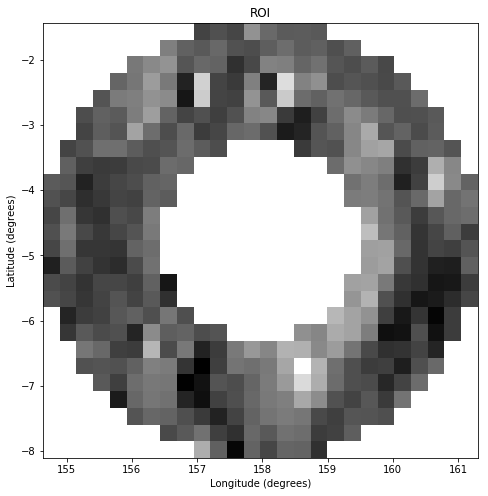

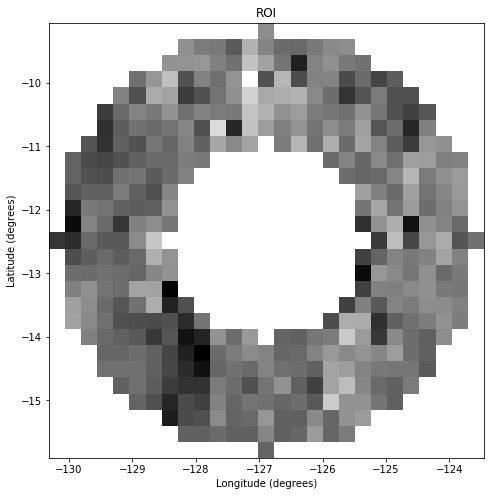

,Rad,Lat,Lon,maximum,mean,median,minimum,pct95,q1,q3
Name,,,,,,,,,,
Olbers D,50.015,10.23,-78.03,141,70.229,68,38,94,61,76.25
Schuster,50.040,4.44,146.42,147,82.715,81,39,110,74,90
Gilbert,50.125,-3.20,76.16,116,60.0864,59,17,82.65,53,66
Ventris,50.370,-4.77,157.97,180,85.1963,82.5,31,127.65,70,97
Fridman,50.725,-12.48,-126.88,129,67.5072,68,17,93,59,77


In [35]:
from acerim import acefunctions as af
statCDF = af.ejecta_stats(moonCDF_20N20S, moonADS, plot=True)
statCDF.head()

**TODO**: here we will explain how the various parts of acefunctions work
